In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from simulation_configs import generateConfigurations
from simulation_modules import DisturbanceModule, ProcessModule, FaultModule, failureCDF, hazardrate
import inspect
import pprint
import pandas as pd

In [2]:
# Repeatable results
np.random.seed(100)

In [3]:
# Generate configurations
t, d, u, p, x, f, y, r, m, econ = generateConfigurations()

In [4]:
# Fault parameters TODO: Better printing of config
pprint.pprint(f)

{'C': {'L': 1296000,
       'alpha': 0.2,
       'drift': 0,
       'drift_rate': 5.787037037037037e-07,
       'fault_type': 'drift',
       'runtime': 0,
       'state': 'none'},
 'C0': {'fault_type': 'none', 'state': 'none'},
 'F': {'fault_type': 'none', 'state': 'none'},
 'F0': {'fault_type': 'none', 'state': 'none'},
 'FW': {'fault_type': 'none', 'state': 'none'},
 'L': {'fault_type': 'none', 'state': 'none'},
 'valveF': {'fault_type': 'none', 'state': 'none'},
 'valveF0': {'fault_type': 'none', 'state': 'none'},
 'valveFW': {'L': 1157760.0,
             'alpha': 0.3,
             'fault_type': 'stuck',
             'runtime': 0,
             'state': 'none',
             'stuck': 0}}


In [5]:
# Fault module
print(inspect.getsource(FaultModule))

def FaultModule(p, x, f, t):
    # Run through all fault IDs
    for fault_id in f.keys():
        # Only consider faults with a fault type that is not none
        if not f[fault_id]['fault_type']=='none':
            # Increase component running time
            f[fault_id]['runtime'] += t['deltat']
            # Calculate current hazard rate
            h = hazardrate(f[fault_id]['runtime'], t['deltat'], f[fault_id]['alpha'], f[fault_id]['L'])
            # Trigger faults according to the probability for failure
            if np.random.uniform()<h or h<0:
                f[fault_id]['state'] = f[fault_id]['fault_type']
            # Adjust drift for currently drifting sensors
            if f[fault_id]['state']=='drift':
                f[fault_id]['drift'] += f[fault_id]['drift_rate']*t['deltat']
    
    return f



In [6]:
# Failure CDF
print(inspect.getsource(failureCDF))

def failureCDF(t_runtime, alpha, L):
    F = 16*(1-alpha)*(t_runtime/L-0.5)**5 + alpha*(t_runtime/L-0.5) + 0.5
    return F



In [7]:
# Hazard rate
print(inspect.getsource(hazardrate))

def hazardrate(t_runtime, dt, alpha, L):
    # R = 1 - F (reliability function)
    R_t = 1-failureCDF(t_runtime, alpha, L)
    R_t_dt = 1-failureCDF(t_runtime+dt, alpha, L)
    # If R_t is a vector, iterate is needed when calculating hazard rate
    if isinstance(R_t, np.ndarray):
        h = np.zeros(len(R_t))
        for i in range(len(R_t)):
            if R_t[i] == 0:
                # Dealing with division by zero
                h[i] = 0
            else:
                # Hazard rate
                h[i] = (R_t[i] - R_t_dt[i])/(dt*R_t[i])
    else:
        # Hazard rate
        if R_t == 0:
            # Dealing with division by zero
            h = 0
        else:
            # Hazard rate
            h = (R_t - R_t_dt)/(dt*R_t)
    return h 



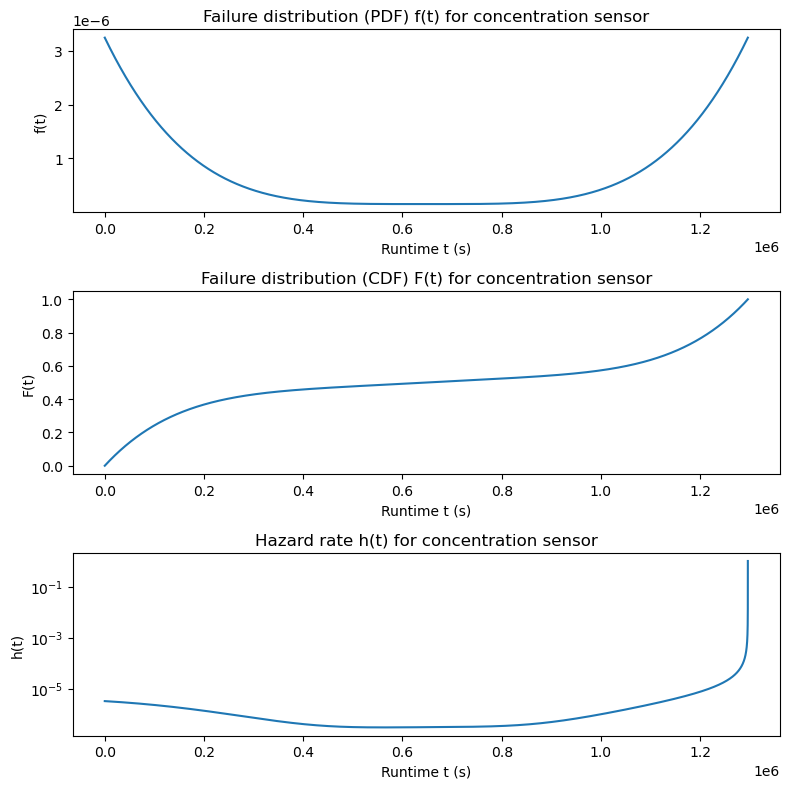

In [8]:
# Example of failure distribution and hazard rate
t_vector = np.arange(0, f['C']['L'], 1)
fig, ax = plt.subplots(3,1,figsize=(8,8))
ax[0].plot(t_vector, np.gradient(failureCDF(t_vector, f['C']['alpha'], f['C']['L']),t_vector[1]-t_vector[0]))
ax[0].set_xlabel('Runtime t (s)')
ax[0].set_ylabel('f(t)')
ax[0].set_title('Failure distribution (PDF) f(t) for concentration sensor')
ax[1].plot(t_vector, failureCDF(t_vector,  f['C']['alpha'], f['C']['L']))
ax[1].set_xlabel('Runtime t (s)')
ax[1].set_ylabel('F(t)')
ax[1].set_title('Failure distribution (CDF) F(t) for concentration sensor')
ax[2].semilogy(t_vector, hazardrate(t_vector, t['deltat'],  f['C']['alpha'], f['C']['L']))
ax[2].set_xlabel('Runtime t (s)')
ax[2].set_ylabel('h(t)')
ax[2].set_title('Hazard rate h(t) for concentration sensor')
plt.tight_layout()
plt.show()

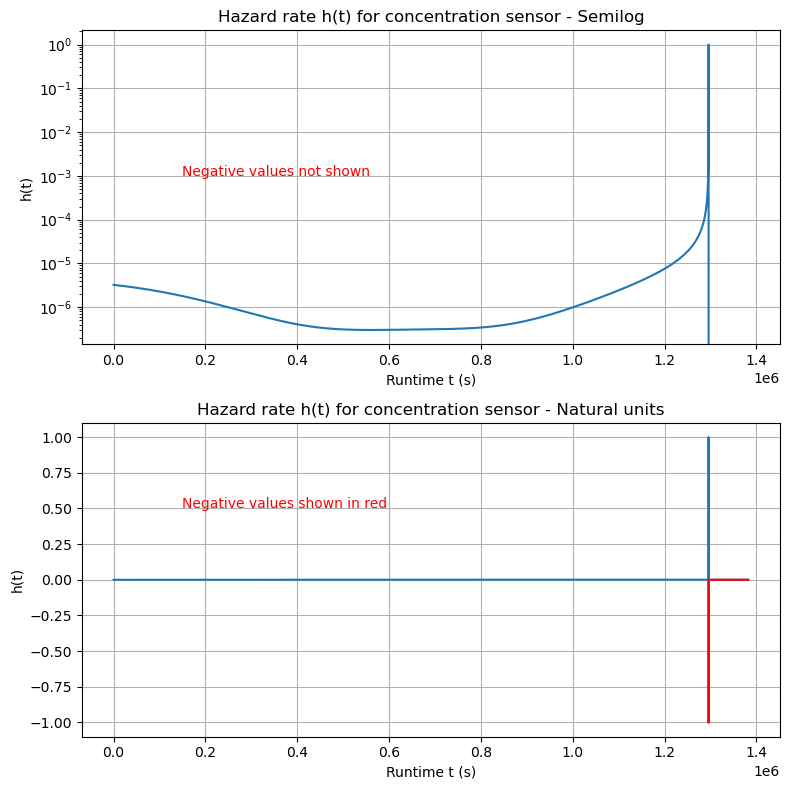

In [9]:
# Hazard rate for periods longer than runtime
full_t = t['tvector']
full_h = hazardrate(full_t, t['deltat'],  f['C']['alpha'], f['C']['L'])
fig, ax = plt.subplots(2,1,figsize=(8,8))
# First plot is semilog (y-axis, which won't show negative values for full range, but x-axis must show full range)
ax[0].semilogy(full_t, full_h)
ax[0].set_xlabel('Runtime t (s)')
ax[0].set_ylabel('h(t)')
ax[0].set_title('Hazard rate h(t) for concentration sensor - Semilog')
ax[0].grid()
ax[0].text(1.5e5, 1e-3, 'Negative values not shown', color='red')
# Second plot is not semilog, so should show all values, for full range, with negative values plotted in red
ax[1].plot(full_t, full_h)
# Find first occurence where hazard rate is negative
first_neg = np.where(hazardrate(full_t, t['deltat'],  f['C']['alpha'], f['C']['L'])<0)[0][0]
ax[1].plot(full_t[first_neg:], full_h[first_neg:], 'r')
ax[1].set_xlabel('Runtime t (s)')
ax[1].set_ylabel('h(t)')
ax[1].set_title('Hazard rate h(t) for concentration sensor - Natural units')
ax[1].grid()
ax[1].text(1.5e5, 0.5, 'Negative values shown in red', color='red')
plt.tight_layout()

In [10]:
# Demonstration of fault module
failure_time_analysis = False
if failure_time_analysis:
    # Simulate many iterations of many periods of operation
    n_iterations = 20
    failure_times = {
        'C':[],
        'valveFW':[]
    }
    # Iterations
    for currentIteration in range(n_iterations):
        # Time
        while t['tvector'][t['i']] < t['tmax']:
            f = FaultModule(p, x, f, t)
            # Faults
            for i, fault_id in enumerate(f.keys()):
                if f[fault_id]['state'] != 'none':
                    # Record failure time
                    failure_times[fault_id].append(f[fault_id]['runtime'])
                    # Reset fault
                    f[fault_id]['state'] = 'none'
                    # Reset runtime
                    f[fault_id]['runtime'] = 0
            # Update time index
            t['i'] = t['i'] + 1
        # Regenerate configurations
        t, d, u, p, x, f, y, r, m = generateConfigurations()

In [11]:
# Plot failure time distribution for two faults
if failure_time_analysis:
    # Dictionary and list comprehension to convert failure times to days
    failure_times_in_days = {key:np.array(value)/(24*3600) for key, value in failure_times.items()}
    fig, ax = plt.subplots(2,1,figsize=(8,8))
    ax[0].hist(failure_times_in_days['C'], bins=100, label='Simulated failure times')
    ax[0].axvline(f['C']['L']/(24*3600), color='red', label='Maximum lifetime')
    ax[0].set_xlabel('Failure time (days)')
    ax[0].set_ylabel('Frequency')
    ax[0].set_title('Failure time distribution for concentration sensor')
    ax[1].hist(failure_times_in_days['valveFW'], bins=100, label='Simulated failure times')
    ax[1].axvline(f['valveFW']['L']/(24*3600), color='red', label='Maximum lifetime')
    ax[1].set_xlabel('Failure time (days)')
    ax[1].set_title('Failure time distribution for water valve')
    ax[1].set_ylabel('Frequency')
    plt.tight_layout()

In [12]:
# Generate disturbances
d_range = DisturbanceModule(d,t)

In [13]:
# Simulation
# List of variables to save
results_list = ['Time (s)', 'V', 'xWv', 'C', 'L', 'F0', 'FW', 'F', 'C0', 'Valve FW fault state']
# Preallocate numpy array to store results
results = np.full((t['N'], len(results_list)),np.nan)
# Start simulation
print('Simulation progress:')
while t['tvector'][t['i']] < t['tmax']:
    # Current disturbance
    d_now = {col: d_range[col][t['i']] for col in ['F0', 'C0']}
    # Process module
    x = ProcessModule(p, u, d_now, x, f)
    # Fault module
    f = FaultModule(p, x, f, t)
    # Update results
    valveFW_state = 0 if f['valveFW']['state']=='none' else 1
    results[t['i'], :] = [t['tvector'][t['i']], 
                          x['V'], 
                          x['xWv'], 
                          x['C'], 
                          x['L'], 
                          x['F0'], 
                          x['FW'], 
                          x['F'], 
                          d_now['C0'],
                          valveFW_state]
    # Display progress in percent time
    if t['i'] % 100000 == 0:
        print(f'{t["tvector"][t["i"]]/t["tmax"]*100:.2f}%')
    # Update time index
    t['i'] += 1

Simulation progress:
0.00%
7.23%
14.47%
21.70%
28.94%
36.17%
43.40%
50.64%
57.87%
65.10%
72.34%
79.57%
86.81%
94.04%


In [14]:
# Convert results (numpy array) to DataFrame
df = pd.DataFrame(results, columns=results_list)
df.set_index('Time (s)', inplace=True)

array([<Axes: xlabel='Time (s)'>, <Axes: xlabel='Time (s)'>,
       <Axes: xlabel='Time (s)'>, <Axes: xlabel='Time (s)'>,
       <Axes: xlabel='Time (s)'>, <Axes: xlabel='Time (s)'>], dtype=object)

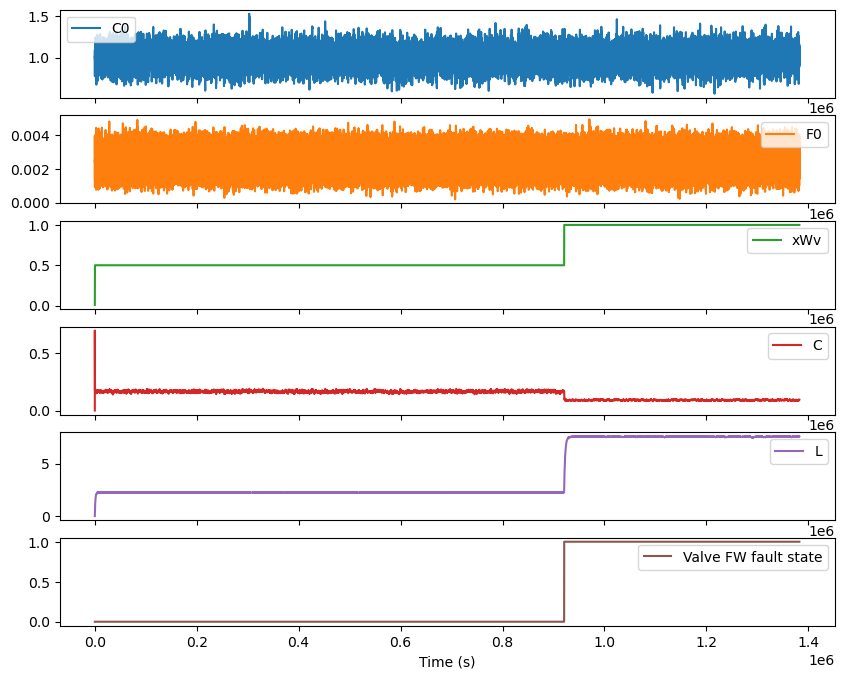

In [15]:
# Plot
#startInd = 650000
#endInd = 700000
startInd = 0
endInd = len(df)
plot_list = ['C0','F0','xWv','C','L','Valve FW fault state']
df[plot_list].iloc[startInd:endInd].plot(subplots=True, figsize=(10,8))